# Predicting Stock Prices with Fourier Transforms

In this notebook, we explore a signal‑processing approach to short‑term stock price forecasting using the Fast Fourier Transform (FFT). By decomposing the historical price series into its constituent sinusoidal modes, we can identify and isolate the dominant cyclic components, remove noise and trends, and then analytically extend each mode beyond the observed window. Summing these extended sinusoids yields a periodic “forecast” that captures the principal oscillatory behavior in the data.


### 1. Compute the full FFT of your training window

$$
X[k] \;=\; \sum_{n=0}^{N-1} x[n] \, e^{-j\,2\pi\,\frac{k\,n}{N}},
\quad k = 0,1,\ldots,N-1.
$$

Each $\hat X[n]$ is complex, carrying both an amplitude $|\hat X[n]|$ and a phase $arg\hat X[n]$.


### 2. Mask out the “noise” bins

Decide on a frequency cutoff $k_{max}$ (or amplitude threshold, our choice) and form

$$
\widetilde X[k]
\;=\;
\begin{cases}
X[k], & \text{if }k \le k_{\max}\text{ or }k \ge N - k_{\max},\\
0,    & \text{otherwise.}
\end{cases}
$$

- We keep the complex $\hat X[n]$ for all “low” bins and their negative‑frequency
- We zero the rest.

### 3. Reconstruct the truncated Fourier series on our training data (sanity check)


$$
\hat x[n]
\;=\;
\frac{1}{N}
\sum_{k=0}^{N-1}
\widetilde X[k]\,
e^{+j\,2\pi\,\frac{k\,n}{N}},
\quad
n = 0,1,\ldots,N-1
$$

This $\hat X[n]$ is a smoothed fit: it’s exactly the sum of the slow sinusoids we preserved.

### 4. Forecast into the future by extending the same sum

Because you still have the phases, you can evaluate

$$
\hat x[n]
\;=\;
\frac{1}{N}
\sum_{k=0}^{N-1}
\widetilde X[k]\,
e^{+j\,2\pi\,\frac{k\,n}{N}},
\quad
n = N,\,N+1,\,\dots
$$

This simply continues each kept sinusoid forward in time. In effect, we've fitted a truncated Fourier series of period $N$ to our data and we are “playing it on” for the next steps.

Loaded AAPL data from nasdaq_top_8.h5


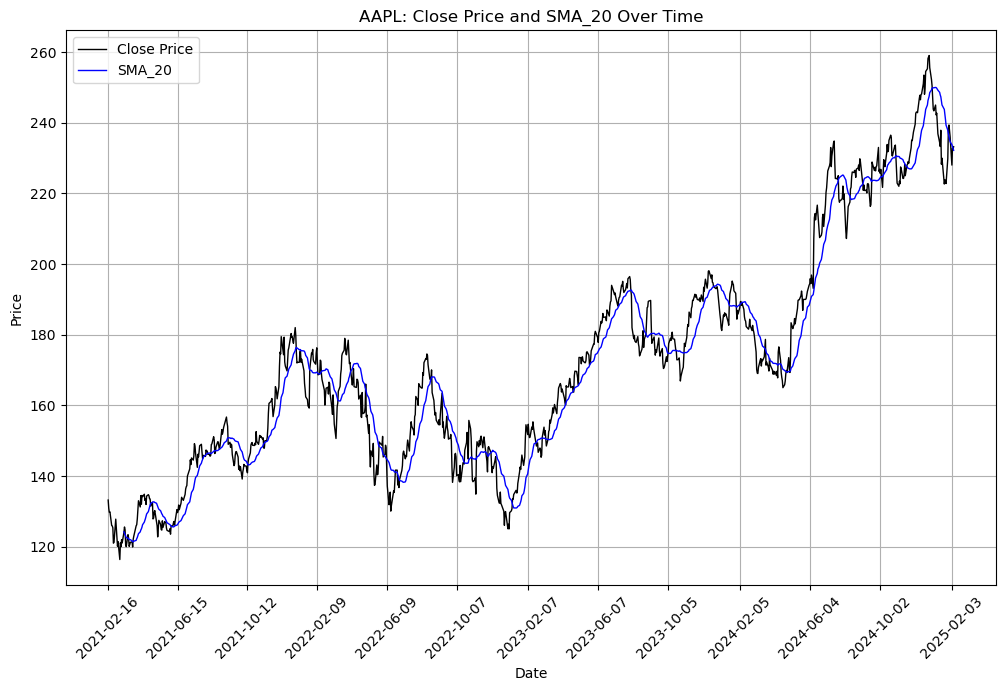

(1000, 7)


,timestamp,open,high,low,close,volume,SMA_20
0,2021-02-16,135.49,136.010,132.79,133.19,80576316,NaN
1,2021-02-17,131.25,132.220,129.47,130.84,97372199,NaN
2,2021-02-18,129.20,129.995,127.41,129.71,96856748,NaN
3,2021-02-19,130.24,130.710,128.80,129.87,87668834,NaN
4,2021-02-22,128.01,129.720,125.60,126.00,102886922,NaN


In [58]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import FFT_utils as u
pd.set_option('display.max_columns', None)

file_path_stock_data = ''

# Load the stock data
hdf_filename = 'nasdaq_top_8.h5'
hdf_file_path = os.path.join(file_path_stock_data, hdf_filename)
nasdaq_symbol_list = ['TSLA', 'NVDA', 'AAPL', 'AMZN', 'MSFT', 'META', 'AMD', 'MRNA']

current_symbol = nasdaq_symbol_list[2]
total_days = 1000

df = u.load_stocks_from_hdf(hdf_file_path, symbol=current_symbol, days=total_days)

u.plot_price(df=df, symbol=current_symbol)
print(df.shape)
df.head()

In [59]:
ratio = 0.5 # Split the data set
df_train = df.iloc[:int(df.shape[0]*ratio)]
df_test = df.iloc[int(df.shape[0]*ratio):]
print(df_train.shape, df_test.shape)

# Extract data
x_train = np.arange(df_train.shape[0])
y_train = df_train['close'].to_numpy()
print(len(x_train), len(y_train))

# Extract data
x_test = np.arange(df_test.shape[0]) + len(x_train)
y_test = df_test['close'].to_numpy()
print(len(x_test), len(y_test))

(500, 7) (500, 7)
500 500
500 500


## Detrend the model

We detrend prices by fitting and removing a low-order polynomial, assuming that trend continues linearly. We then extract dominant cycles via Fourier, assuming those rhythms persist near-term. We keep only the most significant frequency components—believing they encode exploitable structure—and discard the rest as noise. All of these hold only as long as market regime and spectral characteristics remain stable.

A couple comments on our assumptions and motivations:

- Because of general uptrend of stocks over time there will be a huge amplituded in the lowest frequency bins, as the Fourier series tries to approximate this. We want to detrend now so we can gain insights into the important cyclical nature of the stocks then add in the linear trend later on.
- Our ability to determine this cyclical nature is what will gain us the advantage over simply holding the stock.
- We can detrend the stock by fitting a polynomial, however we must be careful. There are several key assumptions that we are making in this Fourier analysis. One is that the polynomial trend we apply will continue into the future, another is that the cyclical nature we see now will also persist into the future. We also assume that we keep only the important frequencies (do not drop important ones and remove all noise that we could not create an advantage from).
- Polynomial fits tend to not be well behaved near the edges which is a concern when we are trying to make forecasts into the future and we cannot trust the behaviour for our most recent data points.

For these reasons we will only perform a 1st order polynomial reduction of the model. Additionally, if we were to use a higher order polynomial we would struggle to forecast as the extrapolation would be much less justifiable and the model would probably be over fit to the historical data. Feel free to try other fits that you think would be valid into the future.

#### Fit a polynomial to the data

Exponential fit parameters: [3.3333227e-02 1.3995098e+02]


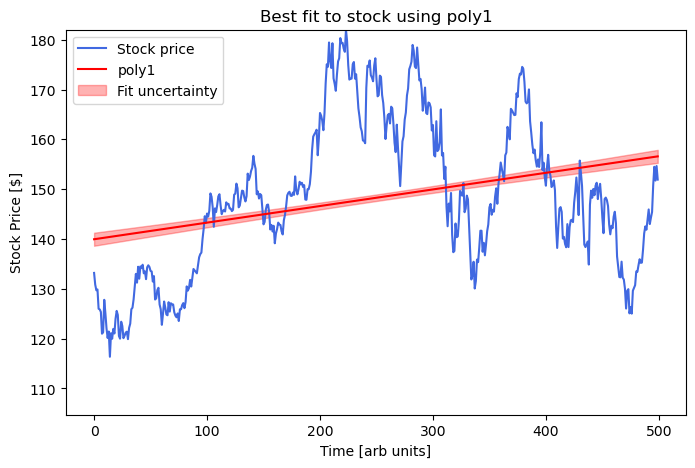

Exponential fit parameters: [-3.92683663e-11  1.16868126e-08]


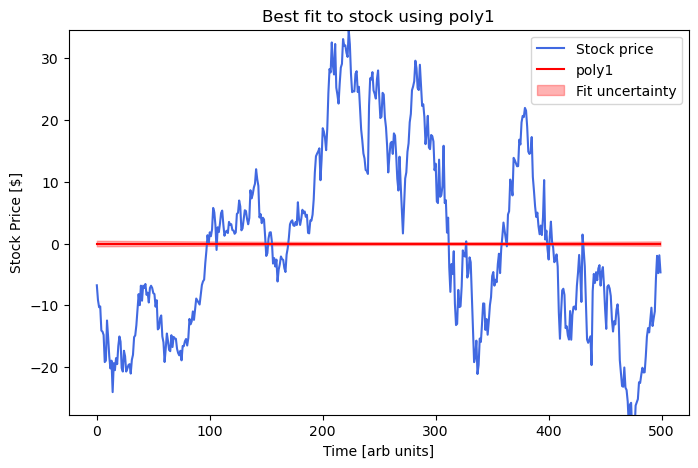

In [60]:
# Dict of modeel fits avaliable:
models = {
    'exp': u.exponential,
    'power_law': u.power_law,
    'poly1': u.poly1,
    'poly2': u.poly2,
    'poly3': u.poly3,
    'poly4': u.poly4,
    'poly5': u.poly5,
    'poly6': u.poly6,
    'logistic': u.logistic
}

p0 = None
model_name = 'poly1'  # Change this to update both name & model
model = models[model_name]

# Fit the exponential model
popt, pcov = u.fit_model(model, x_train, y_train, p0=p0)
print("Exponential fit parameters:", popt)
u.plot_best_fit_with_error(x_train, y_train, popt=popt, pcov=pcov, model=model, model_name=model_name)

# Find the residual
y_fit = model(x_train, *popt)
y_residual = y_train - y_fit # Subraction and division are both valid but we are trying to remove 0th energy bin amplitude

# Check that the fit gets us near 0 parameters on a linear fit to confirm it is detrended
check_model_name = 'poly1'
check_model = models[check_model_name]

# Fit the exponential model
check_popt, check_pcov = u.fit_model(check_model, x_train, y_residual, p0=p0)
print("Exponential fit parameters:", check_popt)

u.plot_best_fit_with_error(x_train, y_residual, popt=check_popt, pcov=check_pcov, model=check_model, model_name=check_model_name)

## Some comments on detrending

### 1. The DC spike comes from the mean (intercept) of our residual

If we fit

$$
r[n] \;=\; x[n] \;-\; p_{5}(n)
$$

where $p_{5}(n)$ is a fifth order polynomial, and then do a first-order fit

$$
r[n]
\;\approx\;
m\,n \;+\; c
$$

we will find $m\;\approx\;-1.6\times 10^{-6}$ (i.e no slope) but $c\;\approx\;1.0008$. That means our “residual” is hovering around +1, not around zero. In the FFT, that constant offset shows up as a huge spike at $k=0$ (the zero-frequency bin).

### 2. Polynomials only remove exactly the behavior they’re fit to

A 5th-order polynomial will perfectly remove any combination of $1,\; n,\; n^2,\; \dots,\; n^5$ but:
- It does not remove slower periodic components (e.g.\ a 300-day cycle), because those aren’t polynomials.
- It does not remove any constant offset unless we explicitly subtract the mean.


### 3. How to clean up that near-zero frequency dominance

1. Choose wisely between dividing or subtracting the polynomial fit.

Depending on the fit the choice of dividing or subtracting the polynomial fit from the data to get the residual can eliminate the amplitude of the lowest frequency bins to a very large degree.

2. Zero to mean.

After subtracting our 5th-order fit, compute

$$
r_{\rm zm}[n]
\;=\;
r[n]
\;-\;
\frac{1}{N}
\sum_{n=0}^{N-1} r[n]
$$

so the new residual has zero average. That will collapse $X[0]$ to near zero.

3. Optionally remove the next few bins.

If we want to remove any very slow drifts or cycles not captured by the polynomial, we can zero out not just $k=0$ but also $k=1,2,…$ up to whatever “ultra‐low” cutoff frequency we choose.

## Perform FFT

In [61]:
# Compute FFT of the signal
fft_result = np.fft.fft(y_residual) # contains the transform: complex numbers containing both amplitude and phase
freqs = np.fft.fftfreq(len(y_residual), d=x_train[1]-x_train[0])

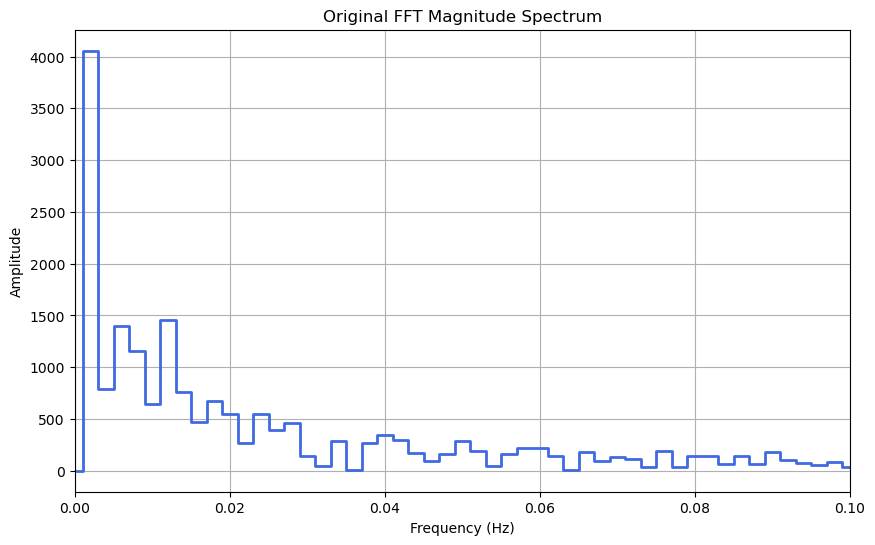

Rank 1: Magnitude = 4056.91, Frequency = 0.002000 Hz, Period = 500.00 days
Rank 2: Magnitude = 1460.20, Frequency = 0.012000 Hz, Period = 83.33 days
Rank 3: Magnitude = 1400.55, Frequency = 0.006000 Hz, Period = 166.67 days
Rank 4: Magnitude = 1155.44, Frequency = 0.008000 Hz, Period = 125.00 days
Rank 5: Magnitude = 790.50, Frequency = 0.004000 Hz, Period = 250.00 days
Rank 6: Magnitude = 758.23, Frequency = 0.014000 Hz, Period = 71.43 days
Rank 7: Magnitude = 676.73, Frequency = 0.018000 Hz, Period = 55.56 days
Rank 8: Magnitude = 640.76, Frequency = 0.010000 Hz, Period = 100.00 days


In [62]:
# Plot the original FFT magnitude spectrum for reference
magnitude = np.abs(fft_result)
positive_mask = freqs >= 0
freqs_positive = freqs[positive_mask]
magnitude_positive = magnitude[positive_mask]

plt.figure(figsize=(10, 6))
plt.step(freqs_positive, magnitude_positive, color="royalblue", lw=2, where='mid')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Original FFT Magnitude Spectrum")
plt.grid(True)
plt.xlim(0.0, 0.1)
#plt.ylim(-0.01, 10000)
plt.show()

top_numbers_to_grab = 8
top_idx = np.argsort(magnitude_positive)[-top_numbers_to_grab:][::-1]
top_freqs = freqs_positive[top_idx]
top_mags = magnitude_positive[top_idx]
top_periods = 1 / top_freqs

for i in range(top_numbers_to_grab):
    print(f"Rank {i+1}: Magnitude = {top_mags[i]:.2f}, Frequency = {top_freqs[i]:.6f} Hz, Period = {top_periods[i]:.2f} days")

## Important clarifications on forecasting workflows

In practice there are two equivalent workflows for forecasting:

### 1. “Cosine‑sum” workflow

1. Pick only the positive‑frequency bins $k = 1,2,\dots,\left\lfloor\frac{N-1}{2}\right\rfloor$
2. Convert each $X_{k}$ into a real sinusoid:

$$
A_k = \frac{2\,\lvert X_k\rvert}{N}
$$

and build

$$
x_k(t) = A_k \cos\!\bigl(\omega_k\,t + \phi_k\bigr)
$$

4. Sum

$$
x(t) = \sum_{k=1}^{\left\lfloor\frac{N-1}{2}\right\rfloor} x_k(t)
$$

Only the positive‑k bins are needed, because we baked in the negative‑frequency contribution via the factor of 2 in $A_{k}$.

### 2. “Truncated‑spectrum IFFT” workflow

1. Zero out all bins except our chosen positive‑frequency bins k, and their conjugate partners at N−k.
2. Call np.fft.ifft() on that truncated spectrum.
3. Tile the resulting real sequence periodically to extend it.

Here we keep both members of each conjugate pair so that the Hermitian symmetry is preserved and the ifft output stays real. Both approaches produce the same periodic extension of our filtered signal. We can pick whichever one feels more straightforward for our forecasting code.

### In this notebook we will go with the first workflow

## Apply a mask

We will remove all frequencies that have amplitudes below a certain threshold. We will also remove the frequency that corresponds to the length of the data set as this is always present but the length of the data set was arbitrary and there is no reason to beleive that that frequency would have real world forecasting significance.

In [63]:
# Create a mask: keep only frequencies with magnitude above threshold
amplitude_mask = magnitude > 500

# Define your frequency exclusion list (in the same units as your FFT frequency axis)
bad_freqs = [1/len(magnitude)]#[1/len(magnitude)] 
tolerance = 1e-6

# Frequency exclusion mask: True if the freq is NOT in the bad list
freq_mask = np.ones_like(freqs, dtype=bool)
for f in bad_freqs:
    freq_mask &= np.abs(freqs - f) > tolerance
    freq_mask &= np.abs(freqs + f) > tolerance  # also exclude negative mirror

# Combine both masks
final_amplitude_mask = amplitude_mask & freq_mask

# Apply the mask
amplitude_filtered_fft = fft_result * final_amplitude_mask

#### We can lot what the componenets of the recomposition looks like

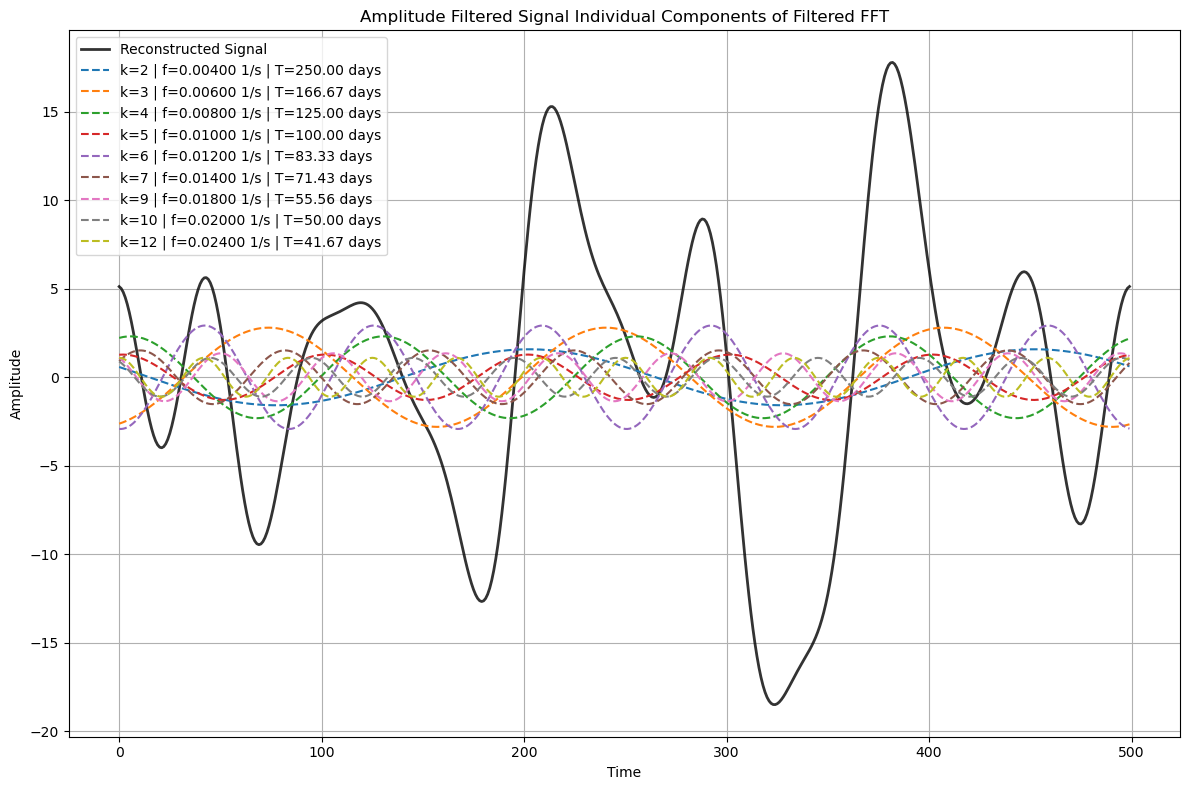

In [64]:
u.plot_fft_components(amplitude_filtered_fft, N=len(amplitude_filtered_fft), title_prefix="Amplitude Filtered Signal")

## Perform IFFT

Try changing the filtering threshold to get an intuition for how well the signal is reconstructed as it is varied.

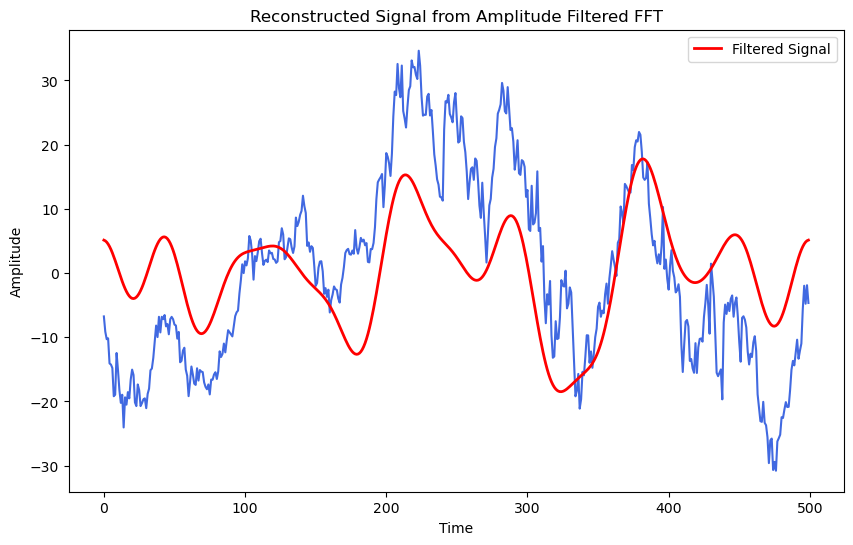

In [65]:
# Inverse FFT
amplitude_filtered_signal = np.fft.ifft(amplitude_filtered_fft)
amplitude_filtered_signal = np.real(amplitude_filtered_signal)  # Remove numerical imaginary parts

# Plot the filtered signal
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_residual, color="royalblue")
plt.plot(x_train, amplitude_filtered_signal, label="Filtered Signal", color="red", lw=2)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Reconstructed Signal from Amplitude Filtered FFT")
plt.legend()
plt.show()

## Forecast into the future

In [66]:
H = len(y_test)  # forecast H steps ahead
x_pred_amplitude = u.fourier_forecast(amplitude_filtered_fft, H)

x_test_clipped = x_test[:H]
y_test_clipped = y_test[:H]

In [67]:
# We detrended by a linear trend so we will add it back in for visual the demostration
def poly1(x, a, b):
    """1st order polynomial: a*x + b"""
    return a * x + b

detrend = poly1(x_test_clipped, popt[0], popt[1])

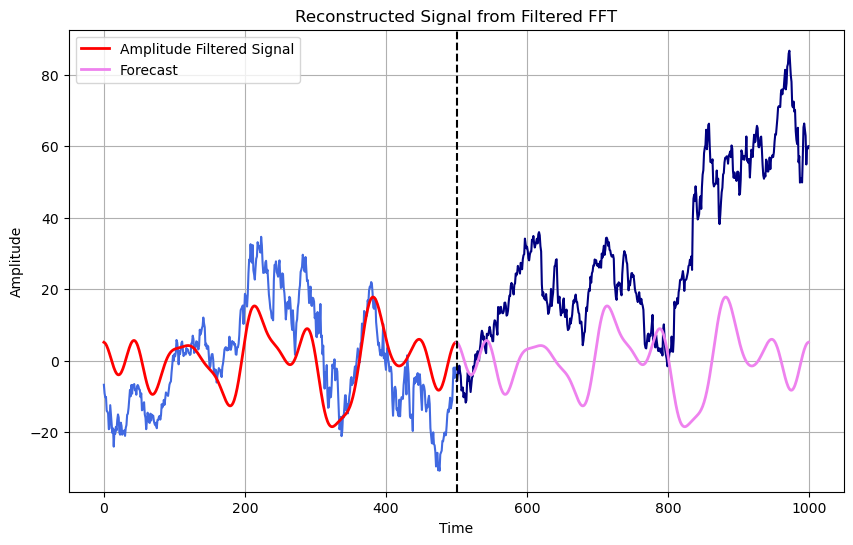

In [68]:
# Plot the filtered signal
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_residual, color="royalblue")
plt.plot(x_train, amplitude_filtered_signal, label="Amplitude Filtered Signal", color="red", lw=2)
plt.plot(x_test_clipped, y_test_clipped-detrend, color='navy')
plt.plot(x_test_clipped, x_pred_amplitude, label="Forecast", color="violet", lw=2)
plt.axvline(len(x_train), color='black', linestyle='--' )

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Reconstructed Signal from Filtered FFT")
plt.legend()
plt.grid(True)
plt.show()

#### Analyzing our results

On first look our forecast appears to be a very poor prediction of the specific price of the stock. However, the information that we are trying to gain from this analysis is not a prediction of the specific stock price the next day or next week; it is to be able to generate educated buy and sell signals that reflect the general up-trends and down-trends over the frequencies that naturally occured in the past stock price. If we buy at a dip and sell at the peak we do not care about the small flucations between those points (noise).

This notebooks thus far is only a simple demonstration of how the Fouier Transform Analysis can be done. It is not a rebustly backtested trading strategy and we have only explored one point in the hyperparameter space of our model.

Future work will include determining a buy/sell signal function for the peaks and troughs of the forecast, deploying that to a robust backtesting pipeline to simulate the expected returns on historical data, and finally a search of the hyperparameter space of the model to determine a more optimal trading strategy. These hyperparameter would include length of historical data and the amplitude threshold that we used to mask the data. From there we can determine how far into the future that we can make viable forecasts.